In [ ]:
!pip install kaggle

In [7]:
!kaggle competitions download -c nlp-getting-started

  0%|                                                | 0.00/593k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 10.2MB/s]


In [28]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 12.3 MB/s eta 0:00:00


In [81]:
!pip install spacy -q

In [83]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from zipfile import ZipFile
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import spacy
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout, Bidirectional, SpatialDropout1D
import json
import re

In [ ]:
sns.set_style("darkgrid")
nltk.download('punkt')

# EDA

In [3]:
tweets_zip = ZipFile('nlp-getting-started.zip', 'r')
tweets_zip.extractall('data')

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
train.head()

In [6]:
print(f'There are {train.shape[0]} rows in the train set and {test.shape[0]} rows in the test set')

There are 7613 rows in the train set and 3263 rows in the test set


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [268]:
train.drop(columns=['keyword', 'location', 'id'], inplace=True)
test.drop(columns=['keyword', 'location', 'id'], inplace=True)

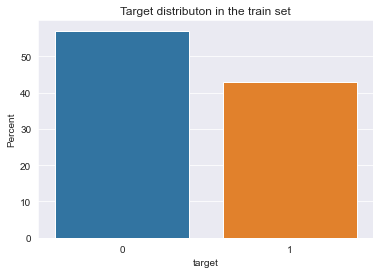

In [10]:
ax = sns.barplot(x='target', y='target', data=train, estimator=lambda x: len(x) / len(train) * 100)
ax.set(ylabel='Percent', title='Target distributon in the train set');

In [269]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [270]:
tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

In [14]:
train['count_sentences'] = train['text'].apply(lambda x : len(sent_tokenize(x)))
train['count_words'] = train['text'].apply(lambda x : len(word_tokenize(x)))
train.head(10)

,id,text,target,count_sentences,count_words
0,1,Our Deeds are the Reason of this #earthquake M...,1,1,14
1,4,Forest fire near La Ronge Sask. Canada,1,2,8
2,5,All residents asked to 'shelter in place' are ...,1,2,24
3,6,"13,000 people receive #wildfires evacuation or...",1,1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,1,18
5,8,#RockyFire Update => California Hwy. 20 closed...,1,2,23
6,10,#flood #disaster Heavy rain causes flash flood...,1,1,17
7,13,I'm on top of the hill and I can see a fire in...,1,1,17
8,14,There's an emergency evacuation happening now ...,1,1,13
9,15,I'm afraid that the tornado is coming to our a...,1,1,12


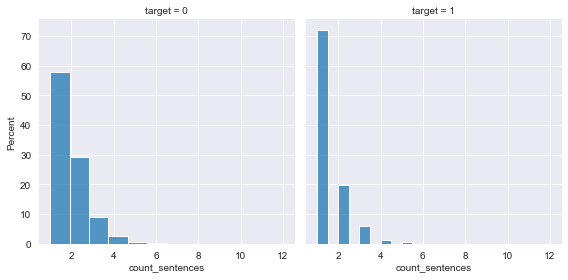

In [15]:
g = sns.FacetGrid(train, col='target', height=4)
g.map(sns.histplot,'count_sentences', bins=12, stat='percent')

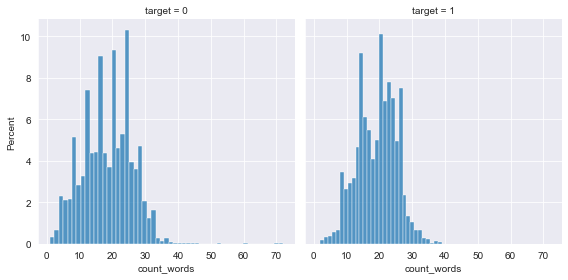

In [16]:
g = sns.FacetGrid(train, col='target', height=4)
g.map(sns.histplot,'count_words', stat='percent')

In [17]:
train_disasters = train[train['target'] == 1]
train_not_disasters = train[train['target'] == 0]

print('For distaster tweets:')
print(f'The mean number of sentences is {round(train_disasters["count_sentences"].mean(),2)} and the median is {train_disasters["count_sentences"].median()}')
print(f'The mean number of words is {round(train_disasters["count_words"].mean(),2)} and the median is {train_disasters["count_words"].median()}')

print('For non distaster tweets:')
print(f'The mean number of sentences is {round(train_not_disasters["count_sentences"].mean(),2)} and the median is {train_not_disasters["count_sentences"].median()}')
print(f'The mean number of words is {round(train_not_disasters["count_words"].mean(),2)} and the median is {train_not_disasters["count_words"].median()}')

For distaster tweets:
The mean number of sentences is 1.4 and the median is 1.0
The mean number of words is 19.26 and the median is 20.0
For non distaster tweets:
The mean number of sentences is 1.6 and the median is 1.0
The mean number of words is 18.66 and the median is 19.0


Disaster tweets are slightly longer

# Preprocessing

In [271]:
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import TweetTokenizer

In [272]:
def preprocess(text):
    text = re.sub('(http|https|ftp)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = ''.join(ch for ch in text if ch.isalnum() or ch==' ')
    text = text.lower().strip()
    text = ' '.join([token.lemma_ for token in nlp(text) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    return text

In [273]:
train['text_clean'] = train['text'].apply(lambda x: preprocess(x))
test['text_clean'] = test['text'].apply(lambda x: preprocess(x))

In [276]:
train.loc[35]

text            On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
target                                                          0
text_clean                             plus look sky night ablaze
text_encoded                                  [22, 706, 185, 462]
len_text                                                       26
Name: 35, dtype: object

In [208]:
# Using TweetTokenizer from NLTK instead of TF Tokenizer as it handles better casual language
#tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
#train['text_tokenize'] = train['text_clean'].apply(lambda x : tknzr.tokenize(x))

In [277]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(train['text_clean'])
train['text_encoded'] = tokenizer.texts_to_sequences(train['text_clean'])
test['text_encoded'] = tokenizer.texts_to_sequences(test['text_clean'])
train['len_text'] = train['text_encoded'].apply(lambda x: len(x))
train = train[train['len_text']!=0]

In [279]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(train['text_encoded'], padding="post")
text_pad

array([[408, 169,   0, ...,   0,   0,   0],
       [117,   2, 159, ...,   0,   0,   0],
       [441, 320, 290, ...,   0,   0,   0],
       ...,
       [437,   5, 389, ...,   0,   0,   0],
       [ 23, 734,  88, ...,   0,   0,   0],
       [107,  25, 357, ...,   0,   0,   0]], dtype=int32)

In [280]:
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, train['target']))

In [281]:
# Train Test Split
TAKE_SIZE = int(0.7*train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(100)

val_data = full_ds.skip(TAKE_SIZE)
val_data = val_data.batch(100)

In [248]:
for tweet, target in train_data.take(1):
    print(tweet, target)

tf.Tensor(
[[172 717 351 ...   0   0   0]
 [ 35 774 323 ...   0   0   0]
 [269 886 963 ...   0   0   0]
 ...
 [  9  30 119 ...   0   0   0]
 [245   0   0 ...   0   0   0]
 [884 235   0 ...   0   0   0]], shape=(100, 18), dtype=int32) tf.Tensor(
[0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0
 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1], shape=(100,), dtype=int64)


# Model selection

## Baseline - SimpleRNN 
### Model

In [335]:
vocab_size = tokenizer.num_words 
model_srnn_baseline = tf.keras.Sequential([       
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  SimpleRNN(units=16, return_sequences=False), # returns the last output
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [336]:
model_srnn_baseline.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 simple_rnn_48 (SimpleRNN)   (None, 16)                784       
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_75 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32,801
Trainable params: 32,801
Non-trainable params: 0
_________________________________________________________________


In [337]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_srnn_baseline.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [338]:
weights = 1/(train['target']).value_counts()
weights = weights * len(train)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.8789890519450269, 1: 1.1596496619545174}

In [339]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_srnn_baseline.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 16:19:22.573331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5409

2022-11-16 16:19:39.950744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 20s 335ms/step - loss: 0.6946 - accuracy: 0.5409 - val_loss: 0.6894 - val_accuracy: 0.5656
Epoch 2/20
53/53 [==============================] - 12s 226ms/step - loss: 0.6856 - accuracy: 0.5693 - val_loss: 0.6860 - val_accuracy: 0.5753
Epoch 3/20
53/53 [==============================] - 12s 219ms/step - loss: 0.6787 - accuracy: 0.6030 - val_loss: 0.6837 - val_accuracy: 0.5801
Epoch 4/20
53/53 [==============================] - 12s 220ms/step - loss: 0.6650 - accuracy: 0.6454 - val_loss: 0.6711 - val_accuracy: 0.6057
Epoch 5/20
53/53 [==============================] - 11s 212ms/step - loss: 0.6349 - accuracy: 0.6924 - val_loss: 0.6491 - val_accuracy: 0.6402
Epoch 6/20
53/53 [==============================] - 12s 221ms/step - loss: 0.5849 - accuracy: 0.7336 - val_loss: 0.6247 - val_accuracy: 0.6658
Epoch 7/20
53/53 [==============================] - 12s 221ms/step - loss: 0.5293 - accuracy: 0.7741 - val_loss: 0.6132 - val_accuracy: 0.6706
Epoch 8/20

In [341]:
model_srnn_baseline.save('models/model_simpleRNN_baseline.h5')
json.dump(model_srnn_baseline.history.history, open('models/simpleRNN_baseline_history.json', 'w'))

### Evaluation

In [342]:
simpleRNN_baseline_history = json.load(open('models/simpleRNN_baseline_history.json', 'r'))

In [343]:
def plot_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    x_lim = len(history['loss']) + 1

    # legend 
    train_line = mlines.Line2D([], [], color='blue', label='Train set')
    val_line = mlines.Line2D([], [], color='red', label='Validation set')

    # Loss
    sns.lineplot(x = range(1,x_lim), y=history['loss'], ax=axes[0], color='blue')
    sns.lineplot(x = range(1,x_lim), y=history['val_loss'], ax=axes[0], color='red')
    axes[0].legend(handles=[train_line, val_line], loc='upper left')
    axes[0].set(xlabel='Epochs', title='Loss')
    axes[0].set_xticks(range(x_lim), labels=range(0,x_lim))

    # Accuracy
    sns.lineplot(x = range(1,x_lim), y=history['accuracy'], ax=axes[1], color='blue')
    sns.lineplot(x = range(1,x_lim), y=history['val_accuracy'], ax=axes[1], color='red')
    axes[1].legend(handles=[train_line, val_line], loc='upper left')
    axes[1].set(xlabel='Epochs', title='Accuracy')
    axes[1].set_xticks(range(x_lim), labels=range(0,x_lim));


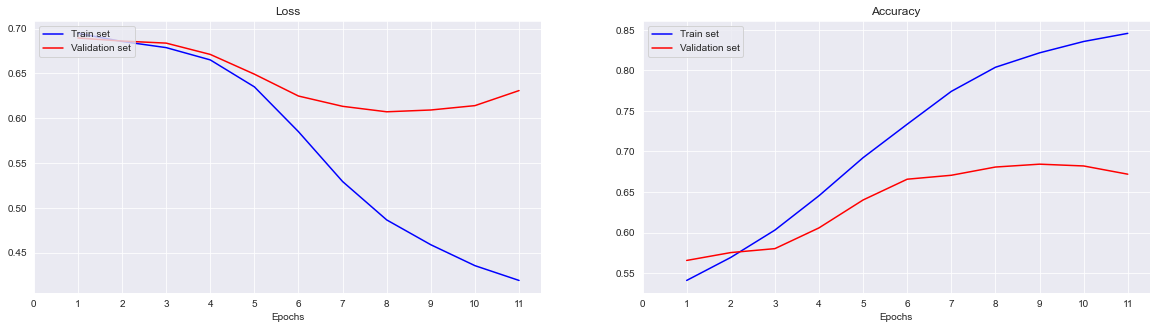

In [344]:
plot_history(simpleRNN_baseline_history)

## GRU
### Model

In [348]:
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  GRU(units=16, return_sequences=False), # returns the last output
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [349]:
model_gru.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 34,417
Trainable params: 34,417
Non-trainable params: 0
_________________________________________________________________


In [355]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [356]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_gru.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 20:58:03.865299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:58:04.145904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:58:05.351110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8444

2022-11-16 20:58:12.087063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:58:12.209017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 10s 145ms/step - loss: 0.3801 - accuracy: 0.8444 - val_loss: 0.5643 - val_accuracy: 0.7214
Epoch 2/20
53/53 [==============================] - 4s 66ms/step - loss: 0.3750 - accuracy: 0.8482 - val_loss: 0.5751 - val_accuracy: 0.7135
Epoch 3/20
53/53 [==============================] - 3s 49ms/step - loss: 0.3733 - accuracy: 0.8501 - val_loss: 0.5775 - val_accuracy: 0.7152
Epoch 4/20
53/53 [==============================] - 2s 38ms/step - loss: 0.3717 - accuracy: 0.8478 - val_loss: 0.5747 - val_accuracy: 0.7188


In [359]:
model_gru.save('models/model_GRU.h5')
json.dump(model_gru.history.history, open('models/GRU_history.json', 'w'))

### Evaluation

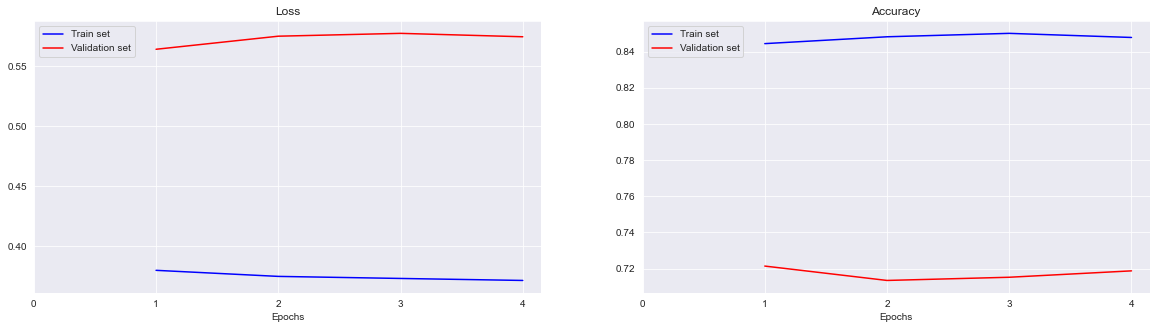

In [361]:
GRU_history = json.load(open('models/GRU_history.json', 'r'))
plot_history(GRU_history)

## LSTM
### Model

In [365]:
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  LSTM(units=16, return_sequences=False), # returns the last output
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [366]:
model_lstm.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_37 (Dropout)        (None, 16)                0         
                                                                 
 dense_79 (Dense)            (None, 1)                 17        
                                                                 
Total params: 35,153
Trainable params: 35,153
Non-trainable params: 0
_________________________________________________________________


In [367]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [368]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_lstm.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 21:03:24.966244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:03:25.304145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:03:26.670086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5148

2022-11-16 21:03:34.267345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:03:34.413216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 13s 161ms/step - loss: 0.6921 - accuracy: 0.5148 - val_loss: 0.6921 - val_accuracy: 0.5673
Epoch 2/20
53/53 [==============================] - 3s 62ms/step - loss: 0.6908 - accuracy: 0.5757 - val_loss: 0.6903 - val_accuracy: 0.5638
Epoch 3/20
53/53 [==============================] - 2s 41ms/step - loss: 0.6891 - accuracy: 0.6062 - val_loss: 0.6873 - val_accuracy: 0.5762
Epoch 4/20
53/53 [==============================] - 2s 41ms/step - loss: 0.6844 - accuracy: 0.6246 - val_loss: 0.6786 - val_accuracy: 0.6084
Epoch 5/20
53/53 [==============================] - 2s 38ms/step - loss: 0.6697 - accuracy: 0.6666 - val_loss: 0.6578 - val_accuracy: 0.6848
Epoch 6/20
53/53 [==============================] - 2s 36ms/step - loss: 0.6221 - accuracy: 0.7501 - val_loss: 0.6018 - val_accuracy: 0.7479
Epoch 7/20
53/53 [==============================] - 2s 34ms/step - loss: 0.5294 - accuracy: 0.8056 - val_loss: 0.5493 - val_accuracy: 0.7479
Epoch 8/20
53/53 [====

In [369]:
model_lstm.save('models/model_LSTM.h5')
json.dump(model_lstm.history.history, open('models/LSTM_history.json', 'w'))

### Evaluation

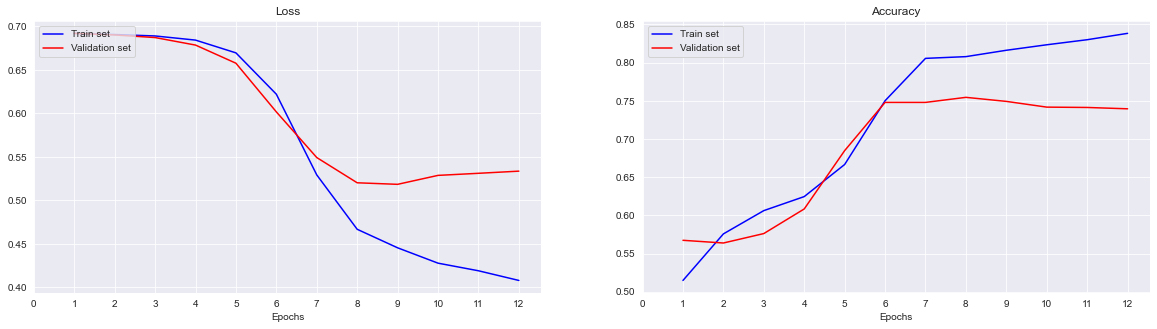

In [370]:
LSTM_history = json.load(open('models/LSTM_history.json', 'r'))
plot_history(LSTM_history)

# LSTM enhancement

In [408]:
model_lstm_2 = tf.keras.Sequential([
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  LSTM(units=16, return_sequences=False), # returns the last output
                  #Dense(16, activation='relu'),
                  Dropout(0.3),
                  Dense(8, activation='relu'),
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [409]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_lstm_2.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_lstm_2.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 22:04:26.347615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:04:26.645508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:04:28.488097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.4477

2022-11-16 22:04:38.618368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:04:38.777574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 15s 215ms/step - loss: 0.6926 - accuracy: 0.4477 - val_loss: 0.6938 - val_accuracy: 0.4437
Epoch 2/20
53/53 [==============================] - 4s 73ms/step - loss: 0.6922 - accuracy: 0.4977 - val_loss: 0.6926 - val_accuracy: 0.5563
Epoch 3/20
53/53 [==============================] - 3s 61ms/step - loss: 0.6921 - accuracy: 0.5320 - val_loss: 0.6920 - val_accuracy: 0.5563
Epoch 4/20
53/53 [==============================] - 3s 58ms/step - loss: 0.6916 - accuracy: 0.5638 - val_loss: 0.6920 - val_accuracy: 0.5567
Epoch 5/20
53/53 [==============================] - 2s 41ms/step - loss: 0.6916 - accuracy: 0.5483 - val_loss: 0.6918 - val_accuracy: 0.5634
Epoch 6/20
53/53 [==============================] - 2s 35ms/step - loss: 0.6914 - accuracy: 0.5570 - val_loss: 0.6917 - val_accuracy: 0.6013
Epoch 7/20
53/53 [==============================] - 2s 33ms/step - loss: 0.6906 - accuracy: 0.5789 - val_loss: 0.6912 - val_accuracy: 0.6852
Epoch 8/20
53/53 [====

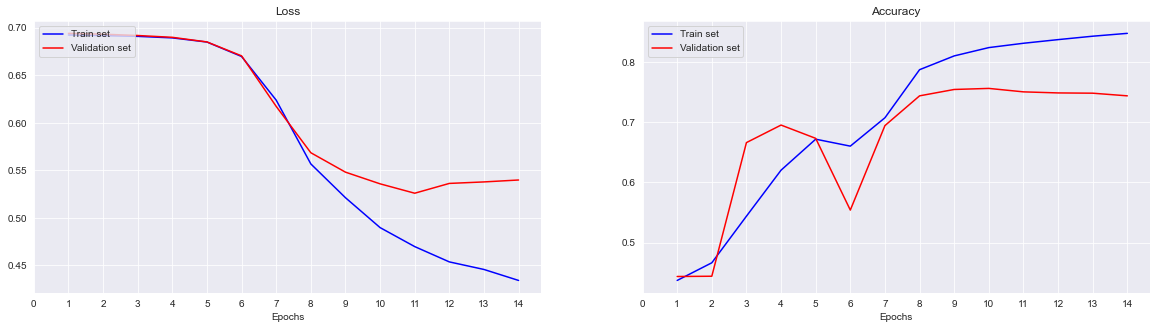

In [407]:
plot_history(model_lstm_2.history.history)

In [413]:
model_lstm_3 = tf.keras.Sequential([
                  Embedding(vocab_size, 128, input_shape=[tweet.shape[1],],name="embedding"),
                  Dropout(0.3),
                  LSTM(units=256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5), # returns the last output
                  Dense(1, activation="sigmoid")
])

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_lstm_3.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_lstm_3.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 22:17:16.597200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.5846

2022-11-16 22:18:16.007061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 64s 1s/step - loss: 0.6671 - accuracy: 0.5846 - val_loss: 0.5692 - val_accuracy: 0.7108
Epoch 2/20
53/53 [==============================] - 47s 893ms/step - loss: 0.5071 - accuracy: 0.7823 - val_loss: 0.5241 - val_accuracy: 0.7488
Epoch 3/20
21/53 [==========>...................] - ETA: 28s - loss: 0.4452 - accuracy: 0.8171

In [ ]:
plot_history(model_lstm_3.history.history)

# Prediction

In [224]:
text_pad_test = tf.keras.preprocessing.sequence.pad_sequences(test['text_encoded'], padding="post", maxlen=tweet.shape[1])
test['prediction'] = model.predict(text_pad_test)
test['prediction'] = test['prediction'].apply(lambda x: 1 if x>0.5 else 0)

102/102 [==============================] - 0s 2ms/step


In [228]:
test.head(25)

,id,text,text_clean,text_encoded,prediction
0,0,Just happened a terrible car crash,happen terrible car crash,"[175, 1541, 45, 14]",0
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[126, 173, 935, 121, 369, 1121]",1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[119, 4, 524, 2805, 1, 2096, 381, 98]",1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[388, 3111, 6224, 69]",1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[395, 526, 12, 4189, 340, 939]",1
5,12,We're shaking...It's an earthquake,shakingit earthquake,"[1, 173]",1
6,21,They'd probably still show more life than Arse...,d probably life arsenal yesterday eh eh,"[85, 570, 43, 2131, 1188, 2898, 2898]",0
7,22,Hey! How are you?,hey,[556],0
8,27,What a nice hat?,nice hat,"[971, 598]",0
9,29,Fuck off!,fuck,[139],0
